-------------
# １．ライブラリのインポート

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.linear_model import Lasso

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

import time

--------
# ２．実験設定

## 2.1 実験設定

In [2]:
### 実験データの設定 ###
TARGET = "visit"  #'conversion', 'visit'
TRAIN_SIZE = 100000
TEST_SIZE = 100000

### 実験設定 ###
SAMPLE_SIZE = 10000  # 標本サイズ
N_TRIALS = 10000  # 試行回数（標本抽出を行う回数）
m_VALUE = 2  # 最適標本配分における各クラスタの最小標本数
RANDOM_STATE = 0  # 乱数シード
SEED = 0

### 実験方法 ###
# クラスタリング
CLUSTERING_METHOD_LIST = ["kmeans"]  # ["gmm", "kmeans", "xmeans"]
N_CLUSTERS = 8  # クラスタ数（Kmeans と GMM）
K_MIN = 2  # 最小クラスタ数（Xmeans)
K_MAX = 10  # 最大クラスタ数(Xmeans)

# 特徴量選択
CRITERION_LIST = [
    "none",
    "lasso",  # "lasso" を選択した場合はalphaも調節する
    "ml",
    "ml(obj)",
    # "checking"
]
LASSO_ALPHA = 0.01  # 選ばれる特徴量の数を確認して調節
SELECT_MAXIMUM_FEATURES = "yes"  # "yes" or "no"（特徴量数が MAXIMUM_FEATURES_TO_SELECT になるまで選ぶかいなか）
MAXIMUM_FEATURES_TO_SELECT = 3  # 選択される最大の特徴量(特徴量選択ありの場合)
FEATURES_LIST_CHECKING = [0]  # 特徴量を指定するとき（特徴量選択基準："checking"の場合)

# 標本配分
ALLOCATION_LIST = [
    "Proportional",
    "Post",
    "Optimal",
]


### 可視化 ###
TITLE_SIZE = 20
LABEL_SIZE = 15
TICK_SIZE = 12.5

## 2.2 各手法の名前

In [3]:
stratification_methods = list(itertools.product(CRITERION_LIST, CLUSTERING_METHOD_LIST))
METHODS_NAME_DICT = {}
for method in stratification_methods:
    if method == ("none", "kmeans"):
        METHODS_NAME_DICT[method] = "Kmeans"
    if method == ("none", "xmeans"):
        METHODS_NAME_DICT[method] = "Xmeans"
    if method == ("none", "gmm"):
        METHODS_NAME_DICT[method] = "GMM"

    if method == ("ml", "kmeans"):
        METHODS_NAME_DICT[method] = "SFS-Kmeans-F"
    if method == ("ml", "xmeans"):
        METHODS_NAME_DICT[method] = "SFS-Xmeans-F"
    if method == ("ml", "gmm"):
        METHODS_NAME_DICT[method] = "SFS-GMM-Loglikelyhood"

    if method == ("checking", "kmeans"):
        METHODS_NAME_DICT[method] = f"Kmeans ({FEATURES_LIST_CHECKING})"
    if method == ("checking", "xmeans"):
        METHODS_NAME_DICT[method] = f"Xmeans ({FEATURES_LIST_CHECKING})"
    if method == ("checking", "gmm"):
        METHODS_NAME_DICT[method] = f"GMM ({FEATURES_LIST_CHECKING})"

    if method == ("lasso", "kmeans"):
        METHODS_NAME_DICT[method] = "Lasso-Kmeans"
    if method == ("lasso", "xmeans"):
        METHODS_NAME_DICT[method] = "Lasso-Xmeans"
    if method == ("lasso", "gmm"):
        METHODS_NAME_DICT[method] = "Lasso-GMM"

    if method == ("ml(obj)", "kmeans"):
        METHODS_NAME_DICT[method] = "SFS-Kmeans-T"
    if method == ("ml(obj)", "xmeans"):
        METHODS_NAME_DICT[method] = "SFS-Xmeans-T"

print("METHODS_NAME_DICT", METHODS_NAME_DICT)

METHODS_NAME_DICT {('none', 'kmeans'): 'Kmeans', ('lasso', 'kmeans'): 'Lasso-Kmeans', ('ml', 'kmeans'): 'SFS-Kmeans-F', ('ml(obj)', 'kmeans'): 'SFS-Kmeans-T'}


-----------
# ３．データの前処理

## 3.1 データ読み込み

In [4]:
df_all = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\criteo-uplift-v2.1.csv.gz", sep=",", header=None
)

df_all.columns = df_all.iloc[0]  # 0行目を列名にする
df_all = df_all[1:].reset_index(drop=True)

column_names = df_all.columns.tolist()

df_control = df_all[df_all["treatment"] == 0]

features_list = [
    "f0",
    "f1",
    "f2",
    "f3",
    "f4",
    "f5",
    "f6",
    "f7",
    "f8",
    "f9",
    "f10",
    "f11",
]
ALL_FEATURES_INDEX = [i for i in range(len(features_list))]

df_train = df_control.iloc[:TRAIN_SIZE]
df_test = df_control.iloc[100000 : TEST_SIZE + 100000]

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_21156\1654035635.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(


## 3.2 欠損値除去

In [5]:
def remove_nan(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    # 各列に対して、pd.to_numericを使用して数値に変換（エラーがあればNaNにする）
    df_numeric = data.apply(lambda col: pd.to_numeric(col, errors="coerce"))

    # 数値に変換できなかった行を抽出（NaNを含む行）
    df_excluded = data[df_numeric.isna().any(axis=1)]

    # NaNを含む行を削除
    df_clean = df_numeric.dropna()

    return df_excluded, df_clean

In [6]:
df_train_ex, df_train_clean = remove_nan(df_train)
df_test_ex, df_test_clean = remove_nan(df_test)

print("全データ数（訓練）：", len(df_train))
print("全データ数（テスト）：", len(df_test))
print("欠損値除去後のデータ数（訓練）：", len(df_train_clean))
print("欠損値除去後のデータ数（テスト）：", len(df_test_clean))

全データ数（訓練）： 100000
全データ数（テスト）： 100000
欠損値除去後のデータ数（訓練）： 100000
欠損値除去後のデータ数（テスト）： 100000


## 3.3 訓練データとテストデータに分割

In [7]:
X_train = df_train[features_list].to_numpy()
y_train = df_train[TARGET].to_numpy()

X_test = df_test[features_list].to_numpy()
y_test = df_test[TARGET].to_numpy()

## 3.4 標準化

In [8]:
sc = StandardScaler()
# 訓練データに基づいてfit
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

-------------
# 4. 特徴量選択

In [9]:
TIME_DICT = {}
SELECTED_FEATURES_DICT = {}

## 4.1 特徴量選択なしの場合

In [10]:
for method, name in METHODS_NAME_DICT.items():
    if method[0] == "none":
        SELECTED_FEATURES_DICT[name] = np.array(ALL_FEATURES_INDEX)
        TIME_DICT[name] = 0
    if method[0] == "checking":
        SELECTED_FEATURES_DICT[name] = np.array(FEATURES_LIST_CHECKING)
        TIME_DICT[name] = 0

## 4.2 Lasso で特徴量選択する場合

In [11]:
def lasso(X: NDArray, y: NDArray, alpha: float) -> list:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    features_list = np.where(lasso.coef_ != 0)[0]
    return features_list

In [12]:
if "lasso" in CRITERION_LIST:
    start_time = time.time()
    selected_features_index = lasso(X_train_std, y_train, alpha=LASSO_ALPHA)
    end_time = time.time()

    for method, name in METHODS_NAME_DICT.items():
        if method[0] == "lasso":
            SELECTED_FEATURES_DICT[name] = selected_features_index
            TIME_DICT[name] = end_time - start_time

    print(selected_features_index)

[4 8 9]


## 4.3 Wrapper法 で特徴量選択する場合

### 準備

In [13]:
class Wrapper(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        maximum_features_to_select: int,
        n_clusters: int,
        criterion: str,
        clustering_method: str,
        random_state: int = 0,
        select_maximum_features: str = "yes",
        k_min: int = 2,
        k_max: int = 10,
    ):
        self.maximum_features_to_select = maximum_features_to_select
        self.n_clusters = n_clusters
        self.criterion = criterion
        self.clustering_method = clustering_method
        self.random_state = random_state
        self.select_maximum_features = select_maximum_features
        self.k_min = k_min
        self.k_max = k_max

    def fss(self, X: NDArray, y: NDArray) -> "Wrapper":
        X, y = check_X_y(X, y)
        n_all_features = X.shape[1]  # 総特徴量数

        ##### 初期化 #####
        features_score_dict = {}  # スコアの推移の確認用
        current_features = []  # 選択された特徴量
        remaining_features = list(range(n_all_features))  # 選択されていない特徴量

        if self.select_maximum_features == "no":
            best_score = -np.inf  # 初期スコア（特徴量を最大数選ぶとは限らないとき）

        ##### 特徴量選択とクラスタリング #####
        while len(current_features) < self.maximum_features_to_select:
            best_feature = None
            if self.select_maximum_features == "yes":
                best_score = -np.inf  # 初期スコア（特徴量を最大数選ぶとき）

            for feature in remaining_features:
                temp_features = current_features + [
                    feature
                ]  # スコアを調べたい特徴量サブセット

                score, labels = self.crit(X[:, temp_features], y)
                if score > best_score:
                    best_score = score
                    best_feature = feature
                    best_labels = np.array(labels)
                    best_cluster_size = np.bincount(best_labels)
                    best_n_clusters = len(np.unique(best_labels))

            # 選択された特徴量をcurrent_featuresに追加し、remaining_features から除外
            if best_feature is not None:
                current_features.append(best_feature)
                remaining_features.remove(best_feature)
                num_of_features = len(current_features)
                print(
                    "num_of_features:",
                    num_of_features,
                    "current_features:",
                    current_features,
                    ", score:",
                    best_score,
                    "best_n_clusters:",
                    best_n_clusters,
                    "best_cluster_size",
                    best_cluster_size,
                )
                features_score_dict[str(num_of_features)] = best_score  # スコア確認用

            else:
                break

        ##### 最終的な特徴量とクラスタリング結果 #####
        self.selected_features_index = current_features
        self.features_score_dict = features_score_dict

        return self

    def crit(self, X: NDArray, y: NDArray) -> tuple[float, list, int]:
        # クラスタリング手法がGMMの場合
        if self.clustering_method == "gmm":
            model = GaussianMixture(
                n_components=self.n_clusters,
                random_state=self.random_state,
                init_params="kmeans",
            )
        if self.clustering_method == "kmeans":
            model = KMeans(
                n_clusters=self.n_clusters,
                random_state=self.random_state,
            )
        if self.clustering_method == "xmeans":
            model = self.xmeans(X)

        model.fit(X)
        labels = model.predict(X)

        if self.criterion == "ml":
            score = model.score(X)
        elif self.criterion == "ml(obj)" and (
            self.clustering_method == "kmeans" or self.clustering_method == "xmeans"
        ):
            tss = 0
            for k in np.unique(labels):
                y_k = y[labels == k]
                mean_y_k = np.mean(y_k)
                tss += np.sum((y_k - mean_y_k) ** 2)
            score = -tss

        return score, labels

    def compute_bic(self, X: NDArray, kmeans: KMeans) -> float:
        # クラスタリング結果の取得
        labels = kmeans.labels_
        clusters = kmeans.cluster_centers_
        n_clusters = len(clusters)
        n = len(X)
        m = X.shape[1]
        # クラスター内の分散の合計
        variance = np.sum(
            [
                np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
                for i in range(n_clusters)
            ]
        )
        # BIC の計算
        bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
        return bic

    def xmeans(self, X: NDArray) -> KMeans:
        kmeans = KMeans(
            n_clusters=self.k_min, random_state=self.random_state
        )  # 初期クラスター数で KMeans を実行
        kmeans.fit(X)
        best_bic = self.compute_bic(X, kmeans)
        best_kmeans = kmeans
        for k in range(self.k_min + 1, self.k_max + 1):
            kmeans = KMeans(n_clusters=k, random_state=self.random_state)
            kmeans.fit(X)
            # BIC を計算
            current_bic = self.compute_bic(X, kmeans)
            # BIC が改善される場合、クラスタ数を更新
            if current_bic < best_bic:
                best_bic = current_bic
                best_kmeans = kmeans
        # 最適なクラスタリング結果を返す
        return best_kmeans

    def get_selected_features_index(self) -> list:
        return self.selected_features_index  # 最終的に選択された特徴量のインデックス

    def get_features_score_dict(self) -> dict:
        return self.features_score_dict  # スコアの推移（確認用）

In [14]:
def process_wrapper(
    instance: "Wrapper", X: NDArray, y: NDArray
) -> tuple[list, dict[int, float]]:
    instance.fss(X, y)
    selected_features_index = instance.get_selected_features_index()
    features_score_dict = instance.get_features_score_dict()
    selected_features_index = np.array(selected_features_index)

    return selected_features_index, features_score_dict

### インスタンスのリスト作成

In [15]:
instances = []
for method, name in METHODS_NAME_DICT.items():
    if method[0] == "ml" or method[0] == "ml(obj)":
        instances.append(
            (
                name,
                Wrapper(
                    maximum_features_to_select=MAXIMUM_FEATURES_TO_SELECT,
                    n_clusters=N_CLUSTERS,
                    criterion=method[0],
                    clustering_method=method[1],
                    random_state=RANDOM_STATE,
                    select_maximum_features=SELECT_MAXIMUM_FEATURES,
                    k_min=K_MIN,
                    k_max=K_MAX,
                ),
            )
        )
print(instances)

[('SFS-Kmeans-F', Wrapper(clustering_method='kmeans', criterion='ml',
        maximum_features_to_select=3, n_clusters=8)), ('SFS-Kmeans-T', Wrapper(clustering_method='kmeans', criterion='ml(obj)',
        maximum_features_to_select=3, n_clusters=8))]


### Wrapper 法実施

In [16]:
features_score_dict_dict = {}  # スコア推移確認用

# 各インスタンスに対して処理を実行
for method_name, instance in instances:
    print("[", method_name, "]")
    start_time = time.time()
    selected_features_index, features_score_dict = process_wrapper(
        instance, X_train_std, y_train
    )
    end_time = time.time()

    SELECTED_FEATURES_DICT[method_name] = selected_features_index
    TIME_DICT[method_name] = end_time - start_time

    features_score_dict_dict[method_name] = features_score_dict  # スコア推移確認用

[ SFS-Kmeans-F ]
num_of_features: 1 current_features: [7] , score: -199.33091344333621 best_n_clusters: 8 best_cluster_size [95109  1066   337   895  1065   490   274   764]
num_of_features: 2 current_features: [7, 1] , score: -2488.826500550147 best_n_clusters: 8 best_cluster_size [95023  2284   583    45    79   138  1847     1]
num_of_features: 3 current_features: [7, 1, 2] , score: -10075.490158045695 best_n_clusters: 8 best_cluster_size [12285 75513  2752    58  1379   583  7225   205]
[ SFS-Kmeans-T ]
num_of_features: 1 current_features: [9] , score: -1590.362520095824 best_n_clusters: 8 best_cluster_size [90024  1400  1788   379  1007  1903  1949  1550]
num_of_features: 2 current_features: [9, 8] , score: -1554.6179356189448 best_n_clusters: 8 best_cluster_size [ 7892  1528 78810  4169  2214  2673  2060   654]
num_of_features: 3 current_features: [9, 8, 2] , score: -1563.6735890958707 best_n_clusters: 8 best_cluster_size [ 8367 74659  1453  2516  2251  4098  5155  1501]


## 4.4 特徴量選択の結果

### Wrapper 法のスコア推移

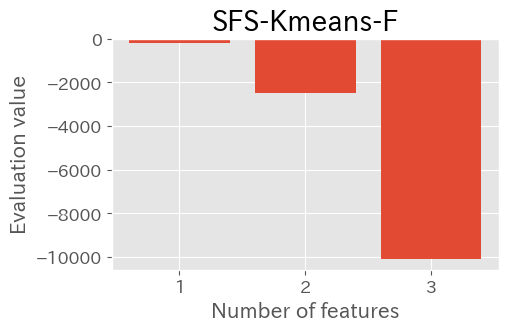

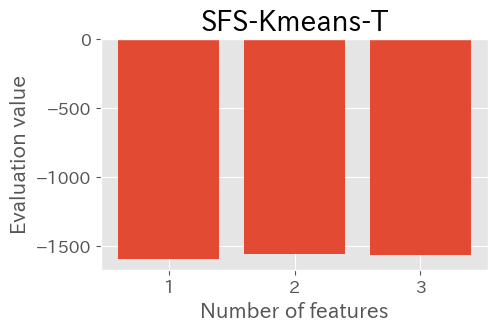

In [17]:
for method_name, instance in instances:
    # 棒グラフを作成
    plt.figure(figsize=(5, 3))
    plt.bar(
        features_score_dict_dict[method_name].keys(),
        features_score_dict_dict[method_name].values(),
    )
    plt.title(f"{method_name}", fontsize=TITLE_SIZE)
    plt.xlabel("Number of features", fontsize=LABEL_SIZE)
    plt.ylabel("Evaluation value", fontsize=LABEL_SIZE)
    # plt.ylim(,)
    plt.tick_params(axis="both", labelsize=TICK_SIZE)
    plt.show()

### 特徴量選択の結果

In [18]:
for _, method_name in METHODS_NAME_DICT.items():
    print(f"【{method_name}】")
    print("選択された特徴量：", SELECTED_FEATURES_DICT[method_name])
    print(f"特徴量選択にかかった時間：{round(TIME_DICT[method_name], 3)} s")
    print()

【Kmeans】
選択された特徴量： [ 0  1  2  3  4  5  6  7  8  9 10 11]
特徴量選択にかかった時間：0 s

【Lasso-Kmeans】
選択された特徴量： [4 8 9]
特徴量選択にかかった時間：13.583 s

【SFS-Kmeans-F】
選択された特徴量： [7 1 2]
特徴量選択にかかった時間：11.497 s

【SFS-Kmeans-T】
選択された特徴量： [9 8 2]
特徴量選択にかかった時間：11.457 s



-----------
# 5. クラスタリングと標本配分

## 5.1 クラスタリング

### 準備

In [19]:
def compute_bic(X: NDArray, kmeans: KMeans) -> float:
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    n_clusters = len(clusters)
    n = len(X)
    m = X.shape[1]
    variance = np.sum(
        [
            np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
            for i in range(n_clusters)
        ]
    )
    bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
    return bic


def xmeans(X: NDArray, k_min: int, k_max: int) -> KMeans:
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    best_bic = compute_bic(X, kmeans)
    best_kmeans = kmeans
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        current_bic = compute_bic(X, kmeans)
        if current_bic < best_bic:
            best_bic = current_bic
            best_kmeans = kmeans
    return best_kmeans

In [20]:
def clustering(
    X_train: NDArray,
    X_test: NDArray,
    methods_name_dict: dict,
    n_clusters: int,
    random_state: int,
    k_min: int,
    k_max: int,
    selected_features_dict: dict,
) -> tuple[dict, dict, dict, dict]:
    cluster_label_dict_train = {}
    cluster_size_dict_train = {}
    cluster_label_dict_test = {}
    cluster_size_dict_test = {}

    for method, name in methods_name_dict.items():
        if method[1] == "kmeans":
            model = KMeans(n_clusters=n_clusters, random_state=random_state)
        if method[1] == "gmm":
            model = GaussianMixture(
                n_components=n_clusters, random_state=random_state, init_params="kmeans"
            )
        if method[1] == "xmeans":
            model = xmeans(X_train, k_min=k_min, k_max=k_max)

        cluster_label_train = model.fit_predict(
            X_train[:, selected_features_dict[name]]
        )
        cluster_size_train = np.bincount(cluster_label_train)
        cluster_label_test = model.predict(X_test[:, selected_features_dict[name]])
        cluster_size_test = np.bincount(cluster_label_test, minlength=n_clusters)

        cluster_label_dict_train[name] = cluster_label_train
        cluster_size_dict_train[name] = cluster_size_train
        cluster_label_dict_test[name] = cluster_label_test
        cluster_size_dict_test[name] = cluster_size_test

    return (
        cluster_label_dict_train,
        cluster_size_dict_train,
        cluster_label_dict_test,
        cluster_size_dict_test,
    )

### クラスタリングの実施

In [21]:
# 訓練データ
(
    CLUSTER_LABEL_DICT_TRAIN,
    CLUSTER_SIZE_DICT_TRAIN,
    CLUSTER_LABEL_DICT_TEST,
    CLUSTER_SIZE_DICT_TEST,
) = clustering(
    X_train=X_train_std,
    X_test=X_test_std,
    methods_name_dict=METHODS_NAME_DICT,
    n_clusters=N_CLUSTERS,
    random_state=RANDOM_STATE,
    k_min=K_MIN,
    k_max=K_MAX,
    selected_features_dict=SELECTED_FEATURES_DICT,
)

In [22]:
def cauculate_cluster_size_dict_for_allocation(
    cluster_size_dict: dict[str, NDArray], min_n_h: int
) -> dict[str, list[int]]:
    cluster_size_dict_for_allocation = {}
    for method_name, cluster_size in cluster_size_dict.items():
        cluster_size_list = []
        for i in range(len(cluster_size)):
            if cluster_size[i] >= min_n_h:
                cluster_size_list.append(cluster_size[i])
        cluster_size_dict_for_allocation[method_name] = cluster_size_list
    return cluster_size_dict_for_allocation


def cauculate_unique_label_dict_for_allocation(
    cluster_size_dict: dict[str, NDArray], min_n_h
) -> dict[str, list[int]]:
    unique_label_dict_for_allocation = {}
    for method_name, cluster_size in cluster_size_dict.items():
        labels = []
        for i in range(len(cluster_size)):
            if cluster_size[i] >= min_n_h:
                labels.append(i)
        unique_label_dict_for_allocation[method_name] = labels
    return unique_label_dict_for_allocation

In [23]:
CLUSTER_SIZE_DICT_FOR_ALLOCATION_TRAIN = cauculate_cluster_size_dict_for_allocation(
    cluster_size_dict=CLUSTER_SIZE_DICT_TRAIN, min_n_h=1
)
UNIQUE_LABEL_DICT_FOR_ALLOCATION_TRAIN = cauculate_unique_label_dict_for_allocation(
    cluster_size_dict=CLUSTER_SIZE_DICT_TRAIN, min_n_h=1
)
CLUSTER_SIZE_DICT_FOR_ALLOCATION_TEST = cauculate_cluster_size_dict_for_allocation(
    cluster_size_dict=CLUSTER_SIZE_DICT_TEST, min_n_h=1
)
UNIQUE_LABEL_DICT_FOR_ALLOCATION_TEST = cauculate_unique_label_dict_for_allocation(
    cluster_size_dict=CLUSTER_SIZE_DICT_TEST, min_n_h=1
)

CLUSTER_SIZE_DICT_FOR_OPTIMAL_TRAIN = cauculate_cluster_size_dict_for_allocation(
    cluster_size_dict=CLUSTER_SIZE_DICT_TRAIN, min_n_h=2
)
UNIQUE_LABEL_DICT_FOR_OPTIMAL_TRAIN = cauculate_unique_label_dict_for_allocation(
    cluster_size_dict=CLUSTER_SIZE_DICT_TRAIN, min_n_h=2
)
CLUSTER_SIZE_DICT_FOR_OPTIMAL_TEST = cauculate_cluster_size_dict_for_allocation(
    cluster_size_dict=CLUSTER_SIZE_DICT_TEST, min_n_h=2
)
UNIQUE_LABEL_DICT_FOR_OPTIMAL_TEST = cauculate_unique_label_dict_for_allocation(
    cluster_size_dict=CLUSTER_SIZE_DICT_TEST, min_n_h=2
)

### クラスタリング結果

In [24]:
print("【訓練データ】")
for _, method_name in METHODS_NAME_DICT.items():
    print(f"{method_name}:{CLUSTER_SIZE_DICT_TRAIN[method_name]}")
    print(
        f"（クラスタサイズが１以上の層のみ：{CLUSTER_SIZE_DICT_FOR_ALLOCATION_TRAIN[method_name]}"
    )
    print(
        f"（クラスタサイズが２以上の層のみ：{CLUSTER_SIZE_DICT_FOR_OPTIMAL_TRAIN[method_name]}"
    )
print()

print("【テストデータ】")
for _, method_name in METHODS_NAME_DICT.items():
    print(f"{method_name}:{CLUSTER_SIZE_DICT_TEST[method_name]}")
    print(
        f"（クラスタサイズが１以上の層のみ：{CLUSTER_SIZE_DICT_FOR_ALLOCATION_TEST[method_name]}"
    )
    print(
        f"（クラスタサイズが２以上の層のみ：{CLUSTER_SIZE_DICT_FOR_OPTIMAL_TEST[method_name]}"
    )

    print(UNIQUE_LABEL_DICT_FOR_OPTIMAL_TRAIN)

【訓練データ】
Kmeans:[ 4507 69353   996  3163  3493 15194   344  2950]
（クラスタサイズが１以上の層のみ：[4507, 69353, 996, 3163, 3493, 15194, 344, 2950]
（クラスタサイズが２以上の層のみ：[4507, 69353, 996, 3163, 3493, 15194, 344, 2950]
Lasso-Kmeans:[ 8202  1898 80819  1129   359  3273  1055  3265]
（クラスタサイズが１以上の層のみ：[8202, 1898, 80819, 1129, 359, 3273, 1055, 3265]
（クラスタサイズが２以上の層のみ：[8202, 1898, 80819, 1129, 359, 3273, 1055, 3265]
SFS-Kmeans-F:[12285 75513  2752    58  1379   583  7225   205]
（クラスタサイズが１以上の層のみ：[12285, 75513, 2752, 58, 1379, 583, 7225, 205]
（クラスタサイズが２以上の層のみ：[12285, 75513, 2752, 58, 1379, 583, 7225, 205]
SFS-Kmeans-T:[ 8367 74659  1453  2516  2251  4098  5155  1501]
（クラスタサイズが１以上の層のみ：[8367, 74659, 1453, 2516, 2251, 4098, 5155, 1501]
（クラスタサイズが２以上の層のみ：[8367, 74659, 1453, 2516, 2251, 4098, 5155, 1501]

【テストデータ】
Kmeans:[ 4386 69342   948  3247  3590 15183   367  2937]
（クラスタサイズが１以上の層のみ：[4386, 69342, 948, 3247, 3590, 15183, 367, 2937]
（クラスタサイズが２以上の層のみ：[4386, 69342, 948, 3247, 3590, 15183, 367, 2937]
{'Kmeans': [0, 1, 2, 

## 5.2 標本配分

### 基底クラス

In [25]:
class BaseAllocation(metaclass=ABCMeta):  # 抽象基底クラス（ABC）
    # 初期化クラス（n_samples(標本サイズ), H(クラスタ数)）
    def __init__(
        self,
        sample_size: int,
        random_state: int,
        method_name: str,
        cluster_size_dict_for_allocation: dict,
    ):
        self.sample_size = sample_size
        self.random_state = random_state
        self.method_name = method_name
        self.N = np.array(cluster_size_dict_for_allocation[self.method_name])

    @abstractmethod
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """標本配分を解く

        Args:
            X (NDArray): データ (N x M)
            y (NDArray): 目的変数 (N)

        Raises:
            NotImplementedError: _description_

        Returns:
            NDArray: 各クラスタの標本数 (H, )

        Note:
            M: 特徴量数
            H: クラスタ数
        """
        raise NotImplementedError

### ① 比例配分（Proportional）

In [26]:
class Proportional(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """各クラスタ数に比例した標本数で分割する"""
        n: NDArray = np.round(self.N / self.N.sum() * self.sample_size).astype(int)

        if n.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n[np.argmax(n)] -= n.sum() - self.sample_size

        if n.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタに足す
            n[np.argmax(n)] += -n.sum() + self.sample_size

        return n

### ② 事後層化（Post）

In [27]:
class Post(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.sample_size])

        return n

### ③ 最適標本配分（Optimal）

In [28]:
class Optimal(BaseAllocation):
    def __init__(
        self,
        sample_size: int,
        random_state: int,
        method_name: str,
        cluster_size_dict_for_allocation: dict,
        cluster_label_dict: dict,
        cluster_size_dict_for_optimal: dict,
        unique_label_dict_for_optimal: dict,
        m_value: int,  # 標本サイズ下限
        M: Optional[NDArray] = None,  # 標本サイズ上限 #Optional(Noneである可能性がある)
    ):
        super().__init__(
            sample_size, random_state, method_name, cluster_size_dict_for_allocation
        )  # 基底クラスBaseAllocation（スーパークラス）の初期化メゾッドを呼び出す
        self.cluster_label = cluster_label_dict[self.method_name]
        self.N_for_optimal = np.array(cluster_size_dict_for_optimal[self.method_name])
        self.labels = unique_label_dict_for_optimal[self.method_name]
        self.m_value = m_value  # 各クラスタの最小標本サイズの配列
        self.M = M  # 各クラスタの最大標本サイズの配列 (指定しない場合はクラスタサイズ)

    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.cluster_label == h]) for h in self.labels])
        d = (self.N_for_optimal**2) * S  # (H, )

        self.m = np.full(len(self.labels), self.m_value)
        n = self._simple_greedy(n=self.m.copy(), d=d)

        # 制約チェック
        self._check_constraints(n)

        return n

    def _simple_greedy(self, n: NDArray, d: NDArray) -> NDArray:
        M = self.M.copy() if self.M is not None else self.N_for_optimal.copy()
        I = np.arange(len(self.labels))  # noqa #クラスタのインデックス配列
        while (n.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(len(self.labels))
            delta[I] = (d / (n + 1) - d / n)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n[h_star] + 1 <= M[h_star]:
                n[h_star] = n[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        return n

    def _check_constraints(self, n: NDArray):
        assert (
            n.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(
            n >= self.m_value
        ), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n <= self.M
            ), "Maximum sample size constraint is not satisfied"

### ポリシーの作成

In [29]:
def create_policies(
    sample_size: int,
    random_state: int,
    methods_name_dict: dict,
    cluster_size_dict_for_allocation: dict,
    cluster_label_dict: dict,
    cluster_size_dict_for_optimal: dict,
    unique_label_dict_for_optimal: dict,
    allocation_list: list,
    m_value: int,
) -> dict[str, list[BaseAllocation]]:
    policies_dict = {}

    for _, method_name in methods_name_dict.items():
        policies: list[BaseAllocation] = []
        if "Proportional" in allocation_list:
            policies.append(
                Proportional(
                    sample_size=sample_size,
                    random_state=random_state,
                    method_name=method_name,
                    cluster_size_dict_for_allocation=cluster_size_dict_for_allocation,
                )
            )
        if "Post" in allocation_list:
            policies.append(
                Post(
                    sample_size=sample_size,
                    random_state=random_state,
                    method_name=method_name,
                    cluster_size_dict_for_allocation=cluster_size_dict_for_allocation,
                )
            )
        if "Optimal" in allocation_list:
            policies.append(
                Optimal(
                    sample_size=sample_size,
                    random_state=random_state,
                    method_name=method_name,
                    cluster_size_dict_for_allocation=cluster_size_dict_for_allocation,
                    cluster_label_dict=cluster_label_dict,
                    cluster_size_dict_for_optimal=cluster_size_dict_for_optimal,
                    unique_label_dict_for_optimal=unique_label_dict_for_optimal,
                    m_value=m_value,
                    M=None,
                )
            )
        policies_dict[method_name] = policies

    return policies_dict

In [30]:
policies_dict_train = create_policies(
    sample_size=SAMPLE_SIZE,
    random_state=RANDOM_STATE,
    m_value=m_VALUE,
    methods_name_dict=METHODS_NAME_DICT,
    cluster_size_dict_for_allocation=CLUSTER_SIZE_DICT_FOR_ALLOCATION_TRAIN,
    cluster_label_dict=CLUSTER_LABEL_DICT_TRAIN,
    cluster_size_dict_for_optimal=CLUSTER_SIZE_DICT_FOR_OPTIMAL_TRAIN,
    unique_label_dict_for_optimal=UNIQUE_LABEL_DICT_FOR_OPTIMAL_TRAIN,
    allocation_list=ALLOCATION_LIST,
)
policies_dict_test = create_policies(
    sample_size=SAMPLE_SIZE,
    random_state=RANDOM_STATE,
    m_value=m_VALUE,
    methods_name_dict=METHODS_NAME_DICT,
    cluster_size_dict_for_allocation=CLUSTER_SIZE_DICT_FOR_ALLOCATION_TEST,
    cluster_label_dict=CLUSTER_LABEL_DICT_TEST,
    cluster_size_dict_for_optimal=CLUSTER_SIZE_DICT_FOR_OPTIMAL_TEST,
    unique_label_dict_for_optimal=UNIQUE_LABEL_DICT_FOR_OPTIMAL_TEST,
    allocation_list=ALLOCATION_LIST,
)

### 標本配分の実施

In [31]:
def cauculate_allocation_dict_dict(
    X: NDArray, y: NDArray, policies_dict: dict
) -> dict[str, dict[str, NDArray]]:
    allocation_dict_dict = {}
    for name, policies in policies_dict.items():
        # それぞれの戦略で各クラスタの標本数を求解
        allocation_dict = {}
        for policy in policies:
            n = policy.solve(X, y)
            allocation_dict[policy.__class__.__name__] = n
        allocation_dict_dict[name] = allocation_dict

    return allocation_dict_dict

In [32]:
ALLOCATION_DICT_DICT_TRAIN = cauculate_allocation_dict_dict(
    X=X_train_std, y=y_train, policies_dict=policies_dict_train
)
ALLOCATION_DICT_DICT_TEST = cauculate_allocation_dict_dict(
    X=X_test_std, y=y_test, policies_dict=policies_dict_test
)

### 標本配分の結果

In [33]:
print("訓練データ")
for _, method_name in METHODS_NAME_DICT.items():
    print(f"【{method_name}】")
    for allocation_method in ALLOCATION_LIST:
        print(
            f"{allocation_method}: {ALLOCATION_DICT_DICT_TRAIN[method_name][allocation_method]}"
        )
    print()

print("テストデータ")
for _, method_name in METHODS_NAME_DICT.items():
    print(f"【{method_name}】")
    for allocation_method in ALLOCATION_LIST:
        print(
            f"{allocation_method}: {ALLOCATION_DICT_DICT_TEST[method_name][allocation_method]}"
        )
    print()

訓練データ
【Kmeans】
Proportional: [ 451 6936  100  316  349 1519   34  295]
Post: [10000]
Optimal: [ 778 2403  605 1499  675 2506  196 1338]

【Lasso-Kmeans】
Proportional: [ 820  190 8082  113   36  327  106  326]
Post: [10000]
Optimal: [1565 1115 3898  428  219  846  669 1260]

【SFS-Kmeans-F】
Proportional: [1228 7553  275    6  138   58  722   20]
Post: [10000]
Optimal: [1064 6540  563   21  213  158 1371   70]

【SFS-Kmeans-T】
Proportional: [ 837 7465  145  252  225  410  516  150]
Post: [10000]
Optimal: [1276 2618  994 1457  597 1242  984  832]

テストデータ
【Kmeans】
Proportional: [ 439 6933   95  325  359 1518   37  294]
Post: [10000]
Optimal: [ 769 2308  570 1480  694 2646  211 1322]

【Lasso-Kmeans】
Proportional: [ 824  185 8081  116   38  328  100  328]
Post: [10000]
Optimal: [1545 1022 4053  454  223  908  604 1191]

【SFS-Kmeans-F】
Proportional: [1236 7545  277    6  144   58  710   24]
Post: [10000]
Optimal: [1205 6360  560   22  226  169 1374   84]

【SFS-Kmeans-T】
Proportional: [ 839 7468 

---------------
# 6. 評価

## 6.1 標本平均の分散を計算（単純無作為抽出）

In [34]:
def cauculate_var_random(y: NDArray, seed: int, n_trials: int, sample_size) -> float:
    np.random.seed(seed)
    y_hats = []
    for i in range(n_trials):
        sample = np.random.choice(y, sample_size, replace=False)
        y_hat_random = sample.mean()
        y_hats.append(y_hat_random)
    var_random = np.array(y_hats).var()

    return var_random

In [35]:
VAR_RANDOM_TRAIN = cauculate_var_random(
    y=y_train, seed=SEED, n_trials=N_TRIALS, sample_size=SAMPLE_SIZE
)
VAR_RANDOM_TEST = cauculate_var_random(
    y=y_test, seed=SEED, n_trials=N_TRIALS, sample_size=SAMPLE_SIZE
)

In [36]:
print(f"訓練データでの標本平均の分散 (Random) : {VAR_RANDOM_TRAIN}")
print(f"テストデータでの標本平均の分散 (Random) : {VAR_RANDOM_TEST}")

訓練データでの標本平均の分散 (Random) : 1.9867628775e-06
テストデータでの標本平均の分散 (Random) : 1.9380202359e-06


## 6.2 標本平均の分散を計算（層化抽出）

### 標本平均を計算する関数

In [37]:
def estimate_y_mean_proportional(
    n: NDArray,
    cluster_label: NDArray,
    cluster_size_for_allocation: list,
    unique_label_for_allocation: list,
    y: NDArray,
) -> float:
    N = np.array(cluster_size_for_allocation)
    weights = N / N.sum()
    y_hat = 0
    i = -1
    for h in unique_label_for_allocation:  # n.shape[0]:層の数
        i += 1
        if n[i] > 0:
            sample: NDArray = np.random.choice(
                y[cluster_label == h], n[i], replace=False
            )
            y_sample_mean = sample.mean()  # サンプリングした標本の平均
            y_hat += y_sample_mean * weights[i]
    return y_hat


def estimate_y_mean_optimal(
    n: NDArray,
    cluster_label: NDArray,
    cluster_size_for_optimal: list,
    unique_label_for_optimal: list,
    y: NDArray,
) -> float:
    N = np.array(cluster_size_for_optimal)
    weights = N / N.sum()
    y_hat = 0
    i = -1
    for h in unique_label_for_optimal:  # n.shape[0]:層の数
        i += 1
        sample: NDArray = np.random.choice(y[cluster_label == h], n[i], replace=False)
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[i]
    return y_hat


def estimate_y_mean_post(
    n: NDArray,
    cluster_label: NDArray,
    cluster_size_for_allocation: list,
    unique_label_for_allocation: list,
    y: NDArray,
) -> float:
    N = np.array(cluster_size_for_allocation)
    weights = N / N.sum()
    y_hat = 0

    all_indices = np.arange(len(y))  # 全データのインデックス
    sample_indices = np.random.choice(all_indices, n[0], replace=False)
    sample_labels = np.array([cluster_label[i] for i in sample_indices])

    for h in np.unique(sample_labels):
        index = np.where(sample_labels == h)[0]
        sample = y[sample_indices[index]]
        y_sample_mean = sample.mean()
        y_hat += y_sample_mean * weights[unique_label_for_allocation.index(h)]
    return y_hat

### 分散を計算する関数

In [38]:
def cauculate_var_stratified_dict_dict(
    y: NDArray,
    seed: int,
    n_trials: int,
    allocation_dict_dict: dict[dict],
    cluster_label_dict: dict,
    cluster_size_dict_for_allocation: dict,
    unique_label_dict_for_allocation: dict,
    cluster_size_dict_for_optimal: dict,
    unique_label_dict_for_optimal: dict,
) -> dict[str, dict[str, float]]:
    np.random.seed(seed)
    var_stratified_dict_dict = {}
    for method_name, allocation_dict in allocation_dict_dict.items():
        var_stratified_dict_dict[method_name] = {}
        for allocation_method, allocation in allocation_dict.items():
            y_hats = []
            for i in range(n_trials):
                if allocation_method == "Post":
                    y_hat = estimate_y_mean_post(
                        n=allocation,
                        cluster_label=cluster_label_dict[method_name],
                        cluster_size_for_allocation=cluster_size_dict_for_allocation[
                            method_name
                        ],
                        unique_label_for_allocation=unique_label_dict_for_allocation[
                            method_name
                        ],
                        y=y,
                    )
                elif allocation_method == "Proportional":
                    y_hat = estimate_y_mean_proportional(
                        n=allocation,
                        cluster_label=cluster_label_dict[method_name],
                        cluster_size_for_allocation=cluster_size_dict_for_allocation[
                            method_name
                        ],
                        unique_label_for_allocation=unique_label_dict_for_allocation[
                            method_name
                        ],
                        y=y,
                    )
                elif allocation_method == "Optimal":
                    y_hat = estimate_y_mean_optimal(
                        n=allocation,
                        cluster_label=cluster_label_dict[method_name],
                        cluster_size_for_optimal=cluster_size_dict_for_optimal[
                            method_name
                        ],
                        unique_label_for_optimal=unique_label_dict_for_optimal[
                            method_name
                        ],
                        y=y,
                    )
                y_hats.append(y_hat)
            y_hats = np.array(y_hats)
            var = y_hats.var()
            var_stratified_dict_dict[method_name][allocation_method] = var

    return var_stratified_dict_dict

### 分散を計算

In [39]:
VAR_STRATIFIED_DICT_DICT_TRAIN = cauculate_var_stratified_dict_dict(
    y=y_train,
    seed=SEED,
    n_trials=N_TRIALS,
    allocation_dict_dict=ALLOCATION_DICT_DICT_TRAIN,
    cluster_label_dict=CLUSTER_LABEL_DICT_TRAIN,
    cluster_size_dict_for_allocation=CLUSTER_SIZE_DICT_FOR_ALLOCATION_TRAIN,
    unique_label_dict_for_allocation=UNIQUE_LABEL_DICT_FOR_ALLOCATION_TRAIN,
    cluster_size_dict_for_optimal=CLUSTER_SIZE_DICT_FOR_OPTIMAL_TRAIN,
    unique_label_dict_for_optimal=UNIQUE_LABEL_DICT_FOR_OPTIMAL_TRAIN,
)
VAR_STRATIFIED_DICT_DICT_TEST = cauculate_var_stratified_dict_dict(
    y=y_test,
    seed=SEED,
    n_trials=N_TRIALS,
    allocation_dict_dict=ALLOCATION_DICT_DICT_TEST,
    cluster_label_dict=CLUSTER_LABEL_DICT_TEST,
    cluster_size_dict_for_allocation=CLUSTER_SIZE_DICT_FOR_ALLOCATION_TEST,
    unique_label_dict_for_allocation=UNIQUE_LABEL_DICT_FOR_ALLOCATION_TEST,
    cluster_size_dict_for_optimal=CLUSTER_SIZE_DICT_FOR_OPTIMAL_TEST,
    unique_label_dict_for_optimal=UNIQUE_LABEL_DICT_FOR_OPTIMAL_TEST,
)

In [40]:
for _, method_name in METHODS_NAME_DICT.items():
    print(f"【{method_name}】")
    print("訓練データでの標本平均の分散")
    print(VAR_STRATIFIED_DICT_DICT_TRAIN[method_name])
    print("テストデータでの標本平均の分散")
    print(VAR_STRATIFIED_DICT_DICT_TEST[method_name])
    print()

【Kmeans】
訓練データでの標本平均の分散
{'Proportional': 1.5274361099747331e-06, 'Post': 1.510185109049579e-06, 'Optimal': 4.915422044556696e-07}
テストデータでの標本平均の分散
{'Proportional': 1.5638228012305397e-06, 'Post': 1.591729594866173e-06, 'Optimal': 5.225456488575671e-07}

【Lasso-Kmeans】
訓練データでの標本平均の分散
{'Proportional': 1.4377485422513724e-06, 'Post': 1.4323897369030035e-06, 'Optimal': 4.589929009809886e-07}
テストデータでの標本平均の分散
{'Proportional': 1.4591590144185246e-06, 'Post': 1.496871138475744e-06, 'Optimal': 5.099507047171925e-07}

【SFS-Kmeans-F】
訓練データでの標本平均の分散
{'Proportional': 1.921293192573209e-06, 'Post': 1.9124267548740503e-06, 'Optimal': 1.6453000817875595e-06}
テストデータでの標本平均の分散
{'Proportional': 1.9006930954227217e-06, 'Post': 1.883614175256809e-06, 'Optimal': 1.5799294210940135e-06}

【SFS-Kmeans-T】
訓練データでの標本平均の分散
{'Proportional': 1.3980563990115886e-06, 'Post': 1.414386341739797e-06, 'Optimal': 3.6194194611075293e-07}
テストデータでの標本平均の分散
{'Proportional': 1.4554301801522847e-06, 'Post': 1.4210812798934739e-06, 

## 6.3 分散削減率の計算

In [41]:
def cauculate_reduction_rate_dict_dict(
    var_stratified_dict_dict: dict, var_random: float
) -> dict[str, dict[str, float]]:
    reduction_rate_dict_dict = {}
    for method_name, dict in var_stratified_dict_dict.items():
        reduction_rate_dict_dict[method_name] = {}
        for allocation_method, var in dict.items():
            reduction_rate = (1 - var / var_random) * 100
            reduction_rate_dict_dict[method_name][allocation_method] = reduction_rate

    return reduction_rate_dict_dict

In [42]:
REDUCTION_RATE_DICT_DICT_TRAIN = cauculate_reduction_rate_dict_dict(
    VAR_STRATIFIED_DICT_DICT_TRAIN, VAR_RANDOM_TRAIN
)

REDUCTION_RATE_DICT_DICT_TEST = cauculate_reduction_rate_dict_dict(
    VAR_STRATIFIED_DICT_DICT_TEST, VAR_RANDOM_TEST
)

In [43]:
print("訓練データ")
for _, method_name in METHODS_NAME_DICT.items():
    print(f"{method_name}:{REDUCTION_RATE_DICT_DICT_TRAIN[method_name]}")

print()

print("テストデータ")
for _, method_name in METHODS_NAME_DICT.items():
    print(f"{method_name}:{REDUCTION_RATE_DICT_DICT_TEST[method_name]}")

訓練データ
Kmeans:{'Proportional': 23.11935524501296, 'Post': 23.98765216763624, 'Optimal': 75.25914088579151}
Lasso-Kmeans:{'Proportional': 27.63361151278746, 'Post': 27.903336974696234, 'Optimal': 76.89744930413877}
SFS-Kmeans-F:{'Proportional': 3.2952943538573365, 'Post': 3.741569941123968, 'Optimal': 17.18689228490683}
SFS-Kmeans-T:{'Proportional': 29.631441434480465, 'Post': 28.809504256514018, 'Optimal': 81.7823279159416}

テストデータ
Kmeans:{'Proportional': 19.308231551859233, 'Post': 17.868267555679708, 'Optimal': 73.03714176055023}
Lasso-Kmeans:{'Proportional': 24.708783355871233, 'Post': 22.76287364044939, 'Optimal': 73.68702889315418}
SFS-Kmeans-F:{'Proportional': 1.9260449290378068, 'Post': 2.807300957718095, 'Optimal': 18.47714529356771}
SFS-Kmeans-T:{'Proportional': 24.90118765574213, 'Post': 26.673558223527227, 'Optimal': 79.20854043072964}


## 6.4 結果のプロット

### プロットするための関数

In [44]:
def plot_bars(
    dicts: list[dict[str, float]],
    var_random: float,
    target: str,
    method_name: str,
    title_size: float,
    label_size: float,
    tick_size: float,
) -> plt.Figure:
    fig, axs = plt.subplots(1, 2, figsize=(8, 2.5))
    ylabels = ["Var reduction rate", "Var"]

    for i, ax in enumerate(axs):
        data = list(dicts[i].values())
        labels = list(dicts[i].keys())
        bars = ax.bar(labels, data)
        if i == 0:
            for bar in bars:
                yval = bar.get_height()  # 各バーの高さ（値）
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    yval,
                    round(yval, 2),
                    ha="center",
                    va="bottom",
                    fontsize=label_size,
                )  # 値をバーの上に表示
        if i == 1:
            ax.bar("Random", var_random, color="blue")
        ax.set_title(method_name, fontsize=title_size)
        ax.set_ylabel(ylabels[i], fontsize=label_size)
        ax.tick_params(axis="both", which="major", labelsize=tick_size)
        ax.set_ylim(0, 50)
    plt.tight_layout()
    plt.show()

### 訓練データの結果

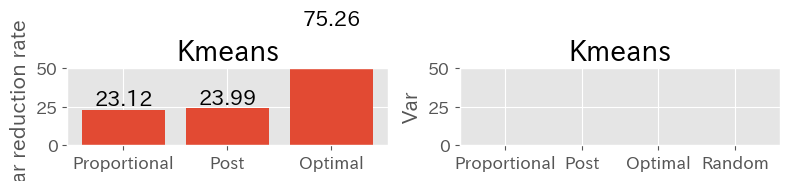

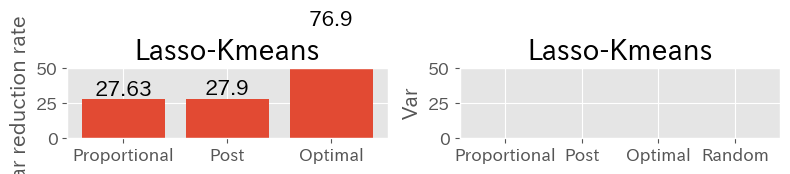

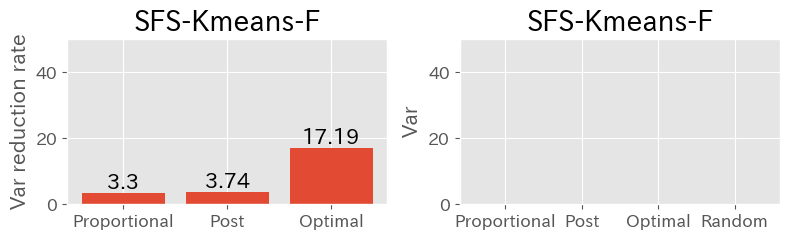

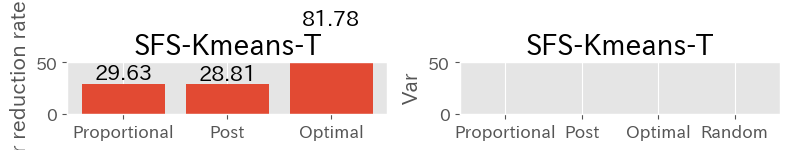

In [45]:
for _, method_name in METHODS_NAME_DICT.items():
    plot_bars(
        dicts=[
            REDUCTION_RATE_DICT_DICT_TRAIN[method_name],
            VAR_STRATIFIED_DICT_DICT_TRAIN[method_name],
        ],
        var_random=VAR_RANDOM_TRAIN,
        target=TARGET,
        method_name=method_name,
        title_size=TITLE_SIZE,
        label_size=LABEL_SIZE,
        tick_size=TICK_SIZE,
    )

### テストデータの結果

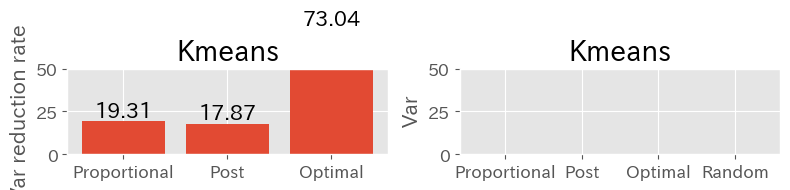

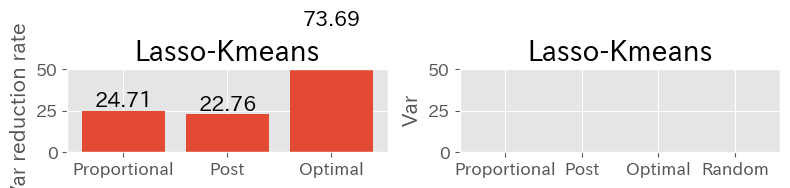

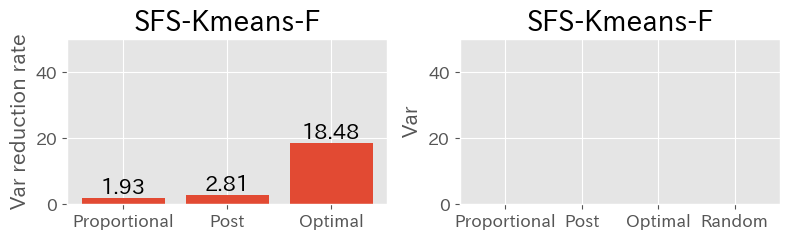

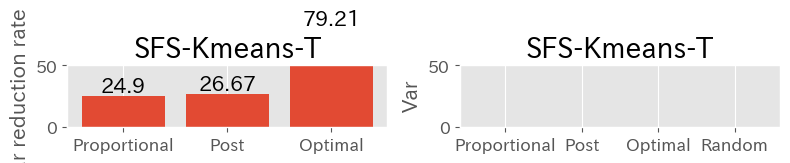

In [46]:
for _, method_name in METHODS_NAME_DICT.items():
    plot_bars(
        dicts=[
            REDUCTION_RATE_DICT_DICT_TEST[method_name],
            VAR_STRATIFIED_DICT_DICT_TEST[method_name],
        ],
        var_random=VAR_RANDOM_TEST,
        target=TARGET,
        method_name=method_name,
        title_size=TITLE_SIZE,
        label_size=LABEL_SIZE,
        tick_size=TICK_SIZE,
    )

### 確認用

In [47]:
print("全データ数（訓練）：", len(df_train))
print("全データ数（テスト）：", len(df_test))
print("欠損値除去後のデータ数（訓練）：", len(df_train_clean))
print("欠損値除去後のデータ数（テスト）：", len(df_test_clean))

全データ数（訓練）： 100000
全データ数（テスト）： 100000
欠損値除去後のデータ数（訓練）： 100000
欠損値除去後のデータ数（テスト）： 100000


In [48]:
# 特徴量選択
for _, method_name in METHODS_NAME_DICT.items():
    print(f"【{method_name}】")
    print("選択された特徴量：", SELECTED_FEATURES_DICT[method_name])
    print(f"特徴量選択にかかった時間：{round(TIME_DICT[method_name], 3)} s")
    print()

【Kmeans】
選択された特徴量： [ 0  1  2  3  4  5  6  7  8  9 10 11]
特徴量選択にかかった時間：0 s

【Lasso-Kmeans】
選択された特徴量： [4 8 9]
特徴量選択にかかった時間：13.583 s

【SFS-Kmeans-F】
選択された特徴量： [7 1 2]
特徴量選択にかかった時間：11.497 s

【SFS-Kmeans-T】
選択された特徴量： [9 8 2]
特徴量選択にかかった時間：11.457 s



In [49]:
# クラスタサイズ
print("【訓練データ】")
for _, method_name in METHODS_NAME_DICT.items():
    print(f"{method_name}:{CLUSTER_SIZE_DICT_TRAIN[method_name]}")

print()

print("【テストデータ】")
for _, method_name in METHODS_NAME_DICT.items():
    print(f"{method_name}:{CLUSTER_SIZE_DICT_TEST[method_name]}")

【訓練データ】
Kmeans:[ 4507 69353   996  3163  3493 15194   344  2950]
Lasso-Kmeans:[ 8202  1898 80819  1129   359  3273  1055  3265]
SFS-Kmeans-F:[12285 75513  2752    58  1379   583  7225   205]
SFS-Kmeans-T:[ 8367 74659  1453  2516  2251  4098  5155  1501]

【テストデータ】
Kmeans:[ 4386 69342   948  3247  3590 15183   367  2937]
Lasso-Kmeans:[ 8245  1846 80810  1163   376  3284   999  3277]
SFS-Kmeans-F:[12363 75449  2774    60  1436   581  7100   237]
SFS-Kmeans-T:[ 8393 74669  1385  2501  2158  4123  5278  1493]


In [50]:
print("var_random_train =", VAR_RANDOM_TRAIN)
print("var_random_test =", VAR_RANDOM_TEST)

var_random_train = 1.9867628775e-06
var_random_test = 1.9380202359e-06


In [51]:
print("var_sep_dict_train =", VAR_STRATIFIED_DICT_DICT_TRAIN)
print("var_sep_dict_test =", VAR_STRATIFIED_DICT_DICT_TEST)

var_sep_dict_train = {'Kmeans': {'Proportional': 1.5274361099747331e-06, 'Post': 1.510185109049579e-06, 'Optimal': 4.915422044556696e-07}, 'Lasso-Kmeans': {'Proportional': 1.4377485422513724e-06, 'Post': 1.4323897369030035e-06, 'Optimal': 4.589929009809886e-07}, 'SFS-Kmeans-F': {'Proportional': 1.921293192573209e-06, 'Post': 1.9124267548740503e-06, 'Optimal': 1.6453000817875595e-06}, 'SFS-Kmeans-T': {'Proportional': 1.3980563990115886e-06, 'Post': 1.414386341739797e-06, 'Optimal': 3.6194194611075293e-07}}
var_sep_dict_test = {'Kmeans': {'Proportional': 1.5638228012305397e-06, 'Post': 1.591729594866173e-06, 'Optimal': 5.225456488575671e-07}, 'Lasso-Kmeans': {'Proportional': 1.4591590144185246e-06, 'Post': 1.496871138475744e-06, 'Optimal': 5.099507047171925e-07}, 'SFS-Kmeans-F': {'Proportional': 1.9006930954227217e-06, 'Post': 1.883614175256809e-06, 'Optimal': 1.5799294210940135e-06}, 'SFS-Kmeans-T': {'Proportional': 1.4554301801522847e-06, 'Post': 1.4210812798934739e-06, 'Optimal': 4.02